# Process Discovery
*by: Sebastiaan J. van Zelst*

Since we have studied basic conceptual knowledge of process mining and event data munging and crunching, we focus on process discovery.
Here, the goal is to discover, i.e., primarily completely automated and algorithmically, a process model that accurately describes the process, i.e., as observed in the event data.
For example, given the running example event data, we aim to discover the process model that we have used to explain the running example's process behavior.
For example, when using the [sample event log](data/running_example.csv) we have seen before, we aim to discover:

![Running example BPMN-based process model describing the behavior of the simple process that we use in this tutorial](img/bpmn_running_example.png)

This section briefly explains what modeling formalisms exist in PM4Py while applying different process discovery algorithms.
Secondly, we give an overview of the implemented process discovery algorithms, their output type(s), and how we can invoke them.
Finally, we discuss the challenges of applying process discovery in practice.
Note that, we will not explain the internal workings of the algorithms presented here.
For more information regarding the algorithmic details, consider the [Coursera MOOC](https://www.coursera.org/learn/process-mining), the papers/articles/web pages we refer to in the notebook, or, contact us for in-depth algorithmic training :-).

## Obtaining a Process Model

There are three different process modeling notations that are currently supported in PM4Py.
These notations are: [BPMN](https://www.bpmn.org/), i.e., models such as the ones shown earlier in this tutorial, *Process Trees* and *Petri nets*.
A Petri net is a more mathematical modeling representation compared to BPMN.
Often, the behavior of a Petri net is more difficult to comprehend compared to BPMN models.
However, due to their mathematical nature, Petri nets are typically less ambiguous (i.e., confusion about their described behavior is not possible).
Process Trees represent a strict subset of Petri nets and describe process behavior in a hierarchical manner.
In this tutorial, we will focus primarily on BPMN models and process trees.
For more information about Petri nets and their application to (business) process modeling (from a ‘workflow’ perspective), we refer to [this article](https://www.researchgate.net/profile/Wil_Aalst/publication/220337578_The_Application_of_Petri_Nets_to_Workflow_Management/links/0deec517a563a45197000000/The-Application-of-Petri-Nets-to-Workflow-Management.pdf?_sg%5B0%5D=2TrqDbNsoZEr67XgOwI_9qxtlO_S1HJFHn8edW7aE0fMWzmsY0D1GhrsbRXdtZhTLvQ1KcSm9pkLzooDMl-eRg.DhnNamQg4EvK8MAwucwkB1VDke7eNq0E4jxMAa2IMXXZtvr9k1PPiwZpQEt1Z2iqkdkN-SOlWyjFloP-BivLow&_sg%5B1%5D=XeHToX2_7feAtM6yO395-HEYttSzdWJeiLaGlD_7Dn3hRXYnVXya0-dHm5RWmjX22gF3ton7d7FSzF6FjL_NYZCQzRvJuPg4zPWnk_HCe0xj.DhnNamQg4EvK8MAwucwkB1VDke7eNq0E4jxMAa2IMXXZtvr9k1PPiwZpQEt1Z2iqkdkN-SOlWyjFloP-BivLow&_iepl=).

Interestingly, none of the algorithms implemented in PM4Py directly discovers a BPMN model.
However, any process tree can easily be translated to a BPMN model.
Since we have already discussed the basic operators of BPMN models, we will start with the discovery of a process tree, which we convert to a BPMN model.
Later, we will study the ‘underlying’ process tree.
The algorithm that we are going to use is the ‘Inductive Miner’;
More details about the (inner workings of the) algorithm can be found in [this presentation](http://www.processmining.org/_media/presentations/2013/petri_nets.pptx) and in [this article](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.396.197&rep=rep1&type=pdf).
Consider the following code snippet showing how to obtain a BPMN model from an event log.

parsing log, completed traces :: 100%|██████████| 150370/150370 [00:08<00:00, 17247.45it/s]


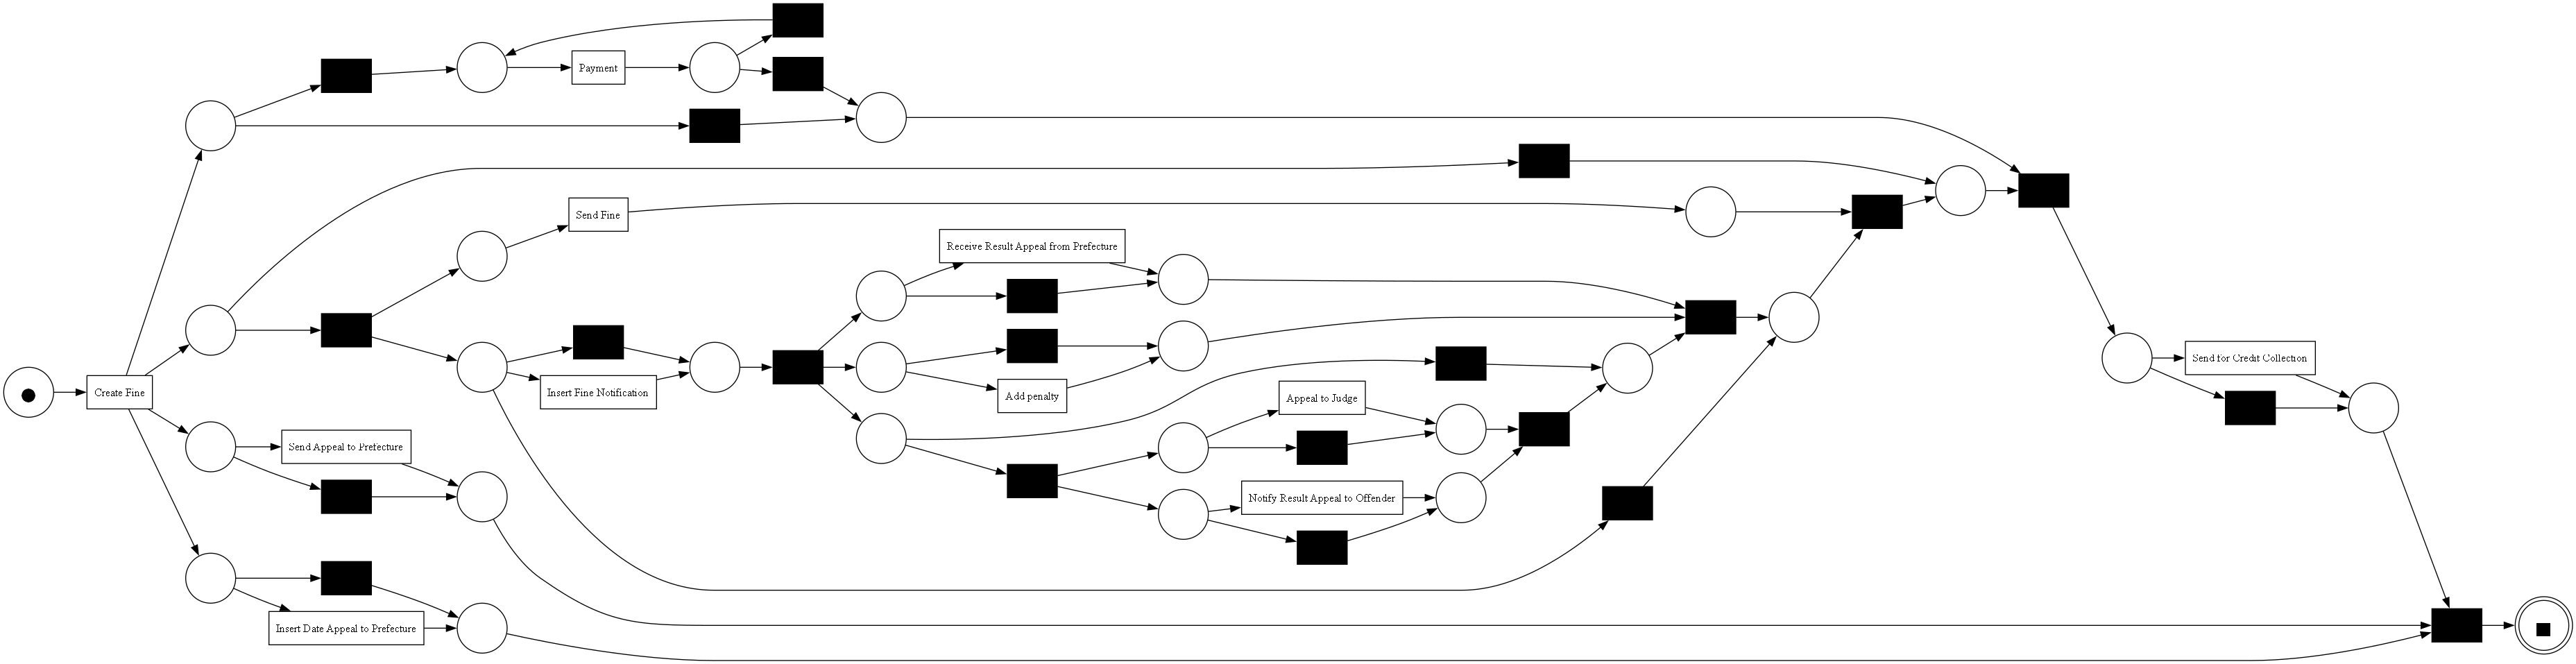

In [ ]:
import pm4py.objects.log.importer.xes.importer as xes_importer
import pm4py

file_path = "data/Road_Traffic_Fine_Management_Process.xes"
log = xes_importer.apply(file_path)
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)

pm4py.view_petri_net(net, initial_marking, final_marking)

In [ ]:
case_duration = pm4py.get_all_case_durations(df)
print(case_duration)

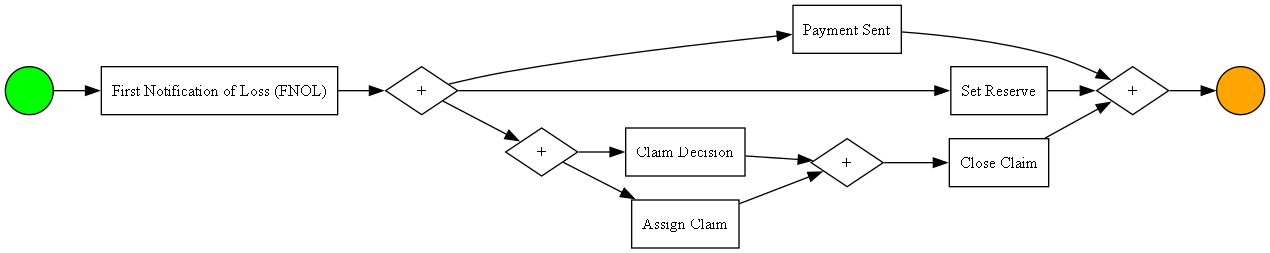

In [2]:
import pandas as pd
import pm4py
df = pm4py.format_dataframe(pd.read_csv('Insurance_claims_event_log.csv', sep=','), case_id='case_id',activity_key='activity_name',
                             timestamp_key='timestamp')
bpmn_model = pm4py.discover_bpmn_inductive(df)
pm4py.view_bpmn(bpmn_model)

Observe that the process model that we discovered, describes the same behavior as the model that we have shown above.

As indicated, the algorithm used in this example actually discovers a *Process Tree*.
Such a process tree is, mathematically speaking, a *rooted tree*, annotated with ‘control-flow’ information.
We’ll first use the following code snippet to discover a process tree based on the running example, and, afterwards shortly analyze the model.

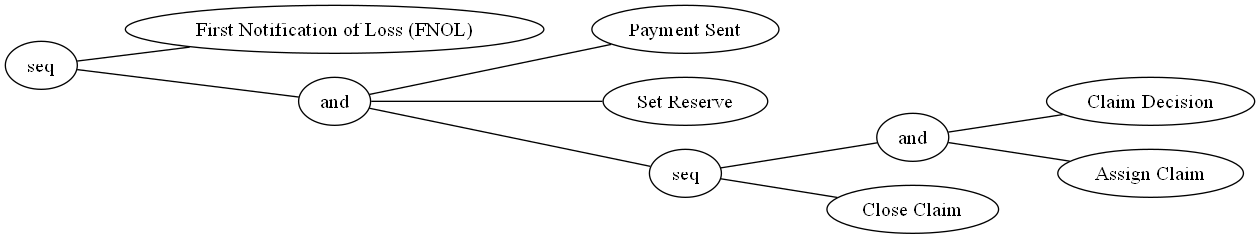

In [3]:
process_tree = pm4py.discover_process_tree_inductive(df)
pm4py.view_process_tree(process_tree)

We'll analyze the process tree model from top to bottom.
The first circle, i.e., the ‘root’ of the process tree, describes a ‘->’ symbol.
This means that, when srolling further down, the process described by the model executes the ‘children’ of the root from left to right.
Hence, first “register request” is executed, followed by the circle node with the ‘\*’ symbol, finally to be followed by the node with the ‘X’ symbol.
The node with the ‘\*’ represents ‘repeated behavior’, i.e., the possibility to repeat the behavior.
When scrolling further down, the left-most ‘subtree’ of the ‘\*’-operator is always executed, the right-most child (in this case, “reinitiate request”) triggers a repeated execution of the left-most child.
Observe that this is in line with the process models we have seen before, i.e., the “reinitiate request” activity allows us to repeat the behavior regarding examinations and checking the ticket.
When we go further down below in the subtree of the ‘\*’-operator, we again observe a ‘->’ node.
Hence, its left-most child is executed first, followed by its right-most child (“decide”).
The left-most child of the ‘->’ node has a ‘+’ symbol.
This represents concurrent behavior; hence, its children can be executed simultaneously or in any order.
Its left-most child is the “check ticket” activity.
Its right-most child is a node with an ‘X’ symbol (just like the right-most child of the tree's root).
This represents an exclusive choice, i.e., one of the children is executed (either “examine casually” or “examine thoroughly”).
Observe that the process tree describes the exact same behavior as the BPMN models shown before.

There are different ways to obtain a petri net:
- Let the algorithm directly return a Petri net.
- Convert the obtained process tree to a Petri net (recall that process trees are a strict sub-class of Petri nets).
For example:

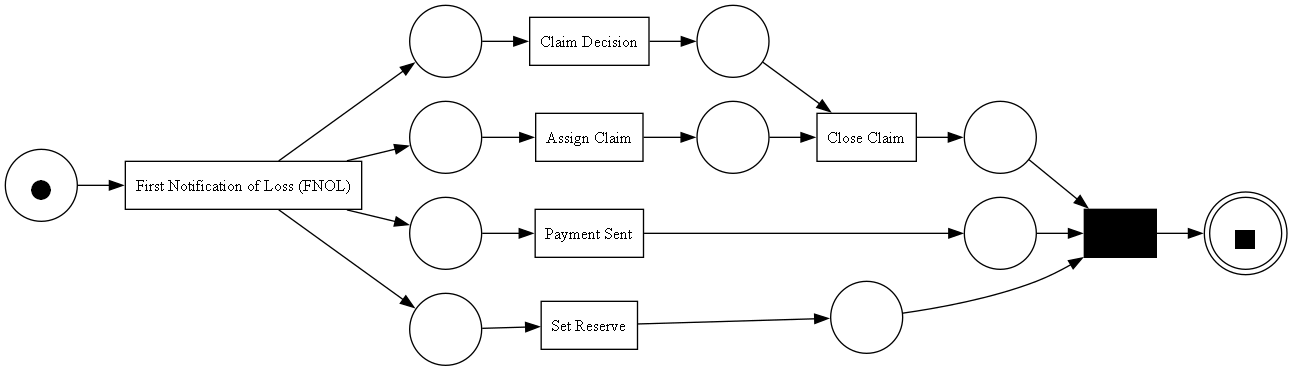

In [4]:
net1, im1, fm1 = pm4py.convert_to_petri_net(process_tree)
pm4py.view_petri_net(net1,im1,fm1)

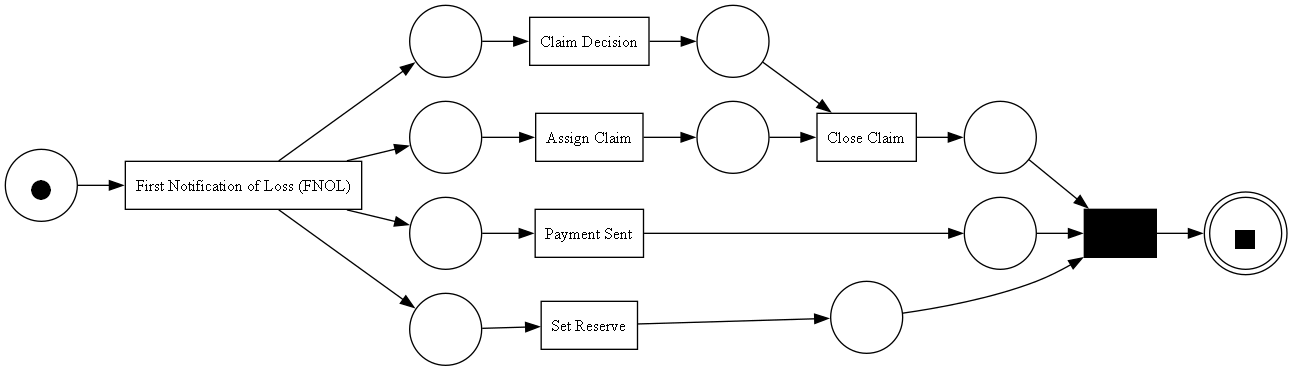

In [5]:
net2, im2, fm2 = pm4py.discover_petri_net_inductive(df)
pm4py.view_petri_net(net2, im2, fm2)

Observe that both functions return three arguments, i.e., the Petri net, an initial and a final marking.
Unsurprisingly, the two models are the same (i.e., the ```pm4py.discover_petri_net_inductive(df)``` function applies the conversion internally).
However, there are alternative algorithms implemented in pm4py, that allow you obtain a Petri net based on an event log.
These algorithms are:
* [The alpha miner](https://en.wikipedia.org/wiki/Alpha_algorithm); One of the first process discovery algorithms
* [The alpha+ miner](https://pure.tue.nl/ws/files/1864325/576199.pdf); Extension of the alpha miner that handles length-one-loops and short loops.

Invocation of the aformentioned algorithms is straightforward:

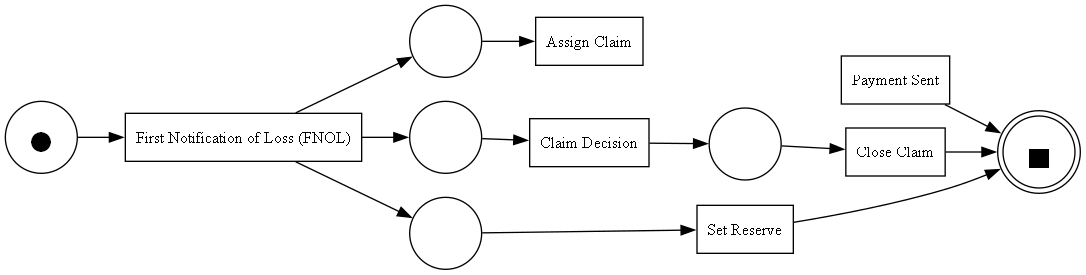

In [6]:
net3, im3, fm3 = pm4py.discover_petri_net_alpha(df)
pm4py.view_petri_net(net3, im3, fm3)

C:\Users\nikba\AppData\Local\Temp\ipykernel_18448\252253649.py:1: DeprecatedWarning: discover_petri_net_alpha_plus is deprecated as of 2.3.0 and will be removed in 3.0.0. This method will be removed in a future release.
  net4, im4, fm4 = pm4py.discover_petri_net_alpha_plus(df)


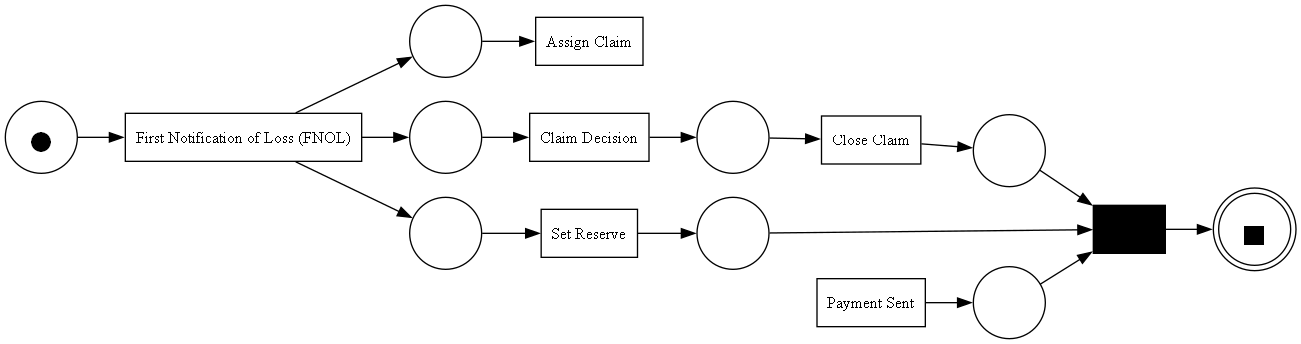

In [7]:
net4, im4, fm4 = pm4py.discover_petri_net_alpha_plus(df)
pm4py.view_petri_net(net4, im4, fm4)

Note that, by definition, the alpha miner variants cannot discover invisible transitions (black boxes).
Additionally, these algorithms have no form of formal quality guarantees w.r.t. the resulting process models.
As such, **we strongly discourage the use of the alpha miners in practice, apart from educational purposes.**

## Obtaining a Process Map

Many [commercial process mining solutions](https://www.gartner.com/reviews/market/process-mining) do not provide extended support for discovering process models.
Often, as a main visualization of processes, *process maps* are used.
A process map contains activities and connections (by means of arcs) between them.
A connection between two activities usually means that there some form of precedence relation.
In its simplest form, it means that the ‘source’ activity directly precedes the ‘target’ activity.
Let’s quickly take a look at a concrete example!
Consider the following code snippet, in which we learn a ‘Directly Follows Graph’ (DFG)-based process map.

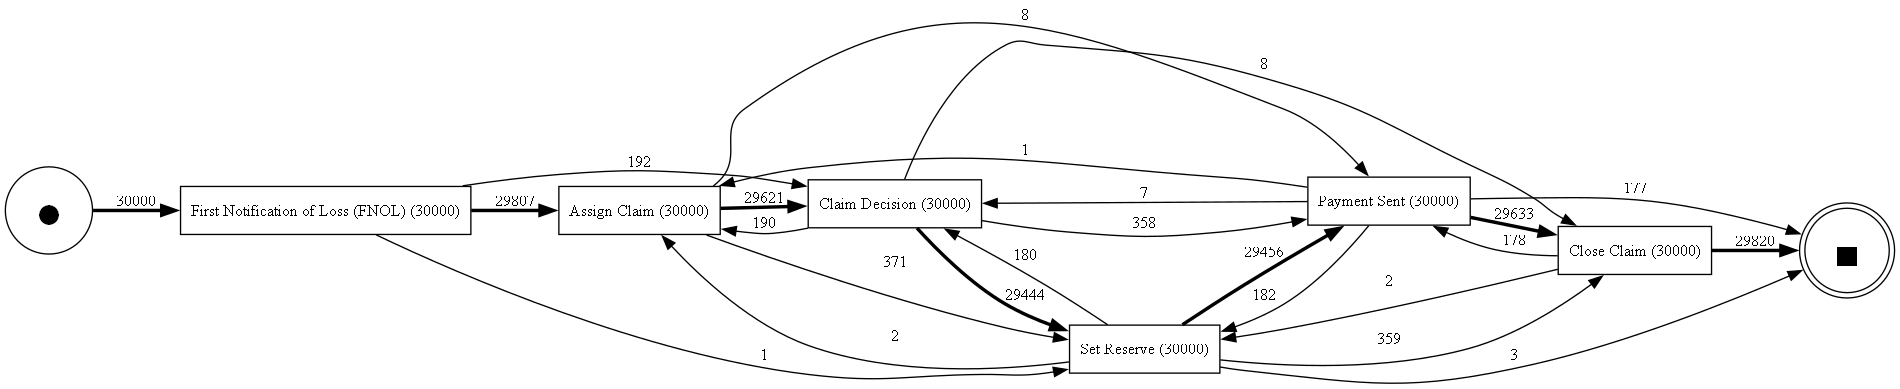

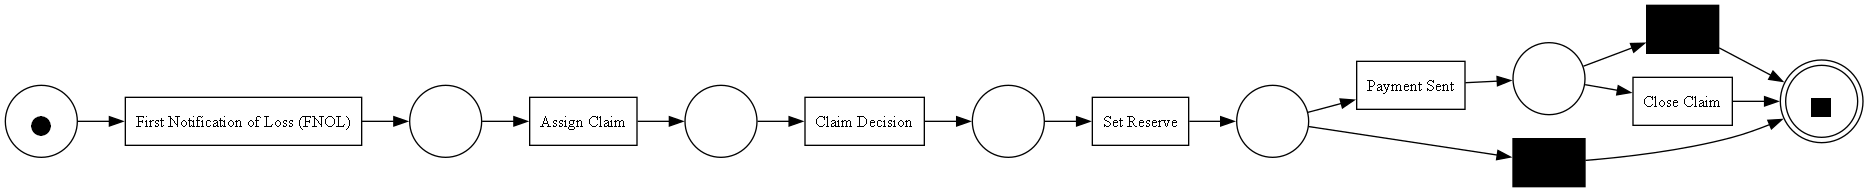

In [14]:
dfg, start_activities, end_activities = pm4py.discover_dfg(df)
pm4py.view_dfg(dfg, start_activities, end_activities)


The pm4py.discover_dfg(log) function returns a triple.
The first result, i.e., called dfg in this example, is a dictionary mapping pairs of activities that follow each other directly, to the number of corresponding observations.
The second and third arguments are the start and end activities observed in the event log (again counters).
In the visualization, the green circle represents the start of any observed process instance.
The orange circle represents the end of an observed process instance.
In 6 cases, the register request is the first activity observed (represented by the arc labeled with value 6).
In the event log, the check ticket activity is executed directly after the register request activity.
The examine thoroughly activity is following registration once, examine casually follows 3 times.
Note that, indeed, in total, the register activity is followed by 6 different events, i.e., there are 6 traces in the running example event log.
However, note that there are typically much more relations observable compared to the number of cases in an event log.
Even using this simple event data, the DFG-based process map of the process is much more complex than the process models learned earlier.
Furthermore, it is much more difficult to infer the actual execution of the process based on the process map.
Hence, when using process maps, one should be very carefully when trying to comprehend the actual process.

In PM4Py, we also implemented the [Heuristics Miner](https://ieeexplore.ieee.org/iel5/5937059/5949295/05949453.pdf), a more advanced process map discovery algorithm, compared to its DFG-based alternative.
We won’t go into the algorithmic details here, however, in a HM-based process map, the arcs between activities represent observed concurrency.
For example, the algorithm is able to detect that the ticket check and examination are concurrent.
Hence, these activities will not be connected in the process map.
As such, a HM-based process map is typically simpler compared to a DFG-based process map.

In [12]:
import pm4py.visualization.petri_net.visualizer  as pn_visualizer

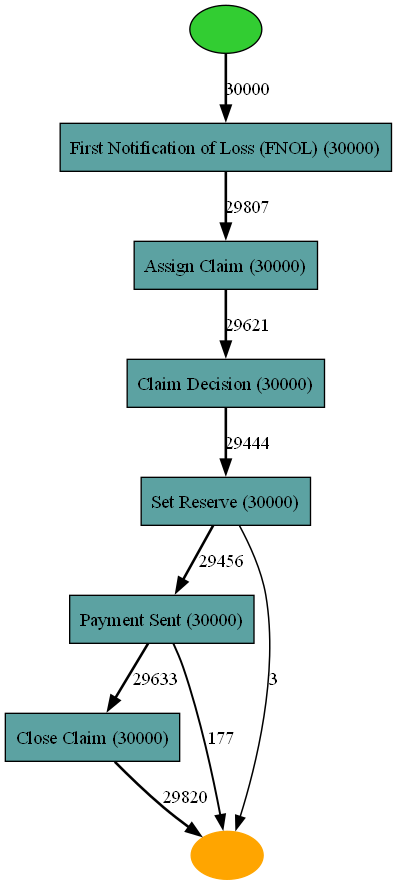

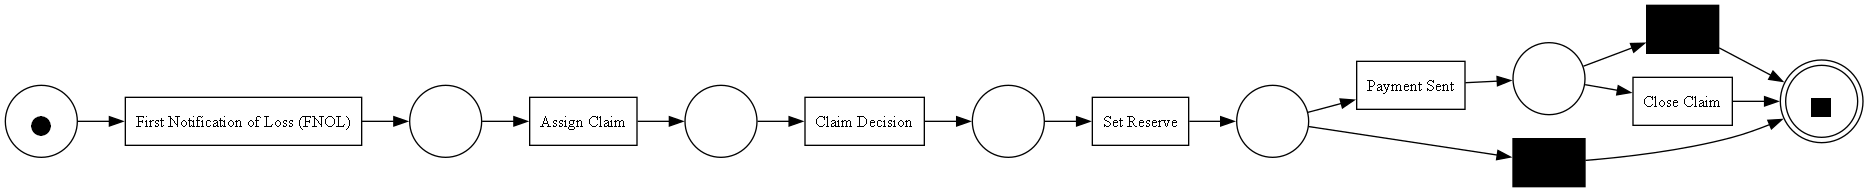

In [ ]:
map = pm4py.discover_heuristics_net(df)
pm4py.view_heuristics_net(map)

net, initial_marking, final_marking = pm4py.convert_to_petri_net(map)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)